In this notebook , a multimodal model based on tensorflow/keras framework is presented.<br />
It has been developped in the scope of a Rakuten challenge whose objective is to classify among 27 classes products sold by this e-commerce major player each item described by texts and one image.<br />
<br />
Here are the main summarized steps :

*   texts and images are preprocessed to become numerical data ready for model.

*   Then, a model using both data source informations has been designed. It is composed of two chains the first one encoding images based on pretrained VGG16 and the second one for the texts built on complementary embedding plus RNN GRU layers .

*   Then, extracted features from both data sources are concatenated to enter the multi Dense classifier with its output layer using softmax activation to predict for each product its probabilities between the 27 classes.


*   Finally, the model is evaluated using the test set to check its ability to generalize correct class predictions on data of new products.



In [1]:
#after gColab VM allocation , list of packages to be installed as not in default environment
#!pip install livelossplot
#!pip install langdetect
#!pip install googletrans==4.0.0-rc1
#Note : spaCy v2.2.4 is already present in environment
#but it isn't compatible for fr_core_news_lg pretrained pipeline
#so upgrade to spaCy 3.2.0 is necessary
#!pip install -U spacy
#!python -m spacy download fr_core_news_lg
#You must restart the runtime in order to use newly installed versions !!!

     |████████████████████████████████| 981 kB 12.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=ff6b4cf26bb9cfc80206a44cf6a069cbe2c88b8bd55a6e3def22cdccea06cc8d
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 1.3 MB 25.5 MB/s 
     |████████████████████████████████| 42 kB 917 kB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 65 kB 3.8 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=b45cb36776abe00a374a387ff9baf5aff59124864465edea643c21c3836019ef
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans
     |████████████████████████████████| 6.0 MB 9.9 MB/s 
     |

In [2]:
# Google Colab
from google.colab import drive
%tensorflow_version 2.x

# System
import sys
import os
import time

import warnings
warnings.filterwarnings("ignore")

# visualisation library
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

# Data Science useful python librairies
import numpy as np
import pandas as pd

#preprocessing text libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from langdetect import detect
from googletrans import Translator
translator = Translator(service_urls=['translate.google.com'])
import spacy
#large pretrained pipeline model
nlp = spacy.load('fr_core_news_lg')

#preprocessing image library
import cv2

# DL framework
import tensorflow as tf
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot import PlotLossesKerasTF

from tensorflow.keras.layers import Dense,Dropout,Flatten,Embedding,GRU,MaxPooling1D,GlobalMaxPooling1D,BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16

#scikit learn library
from sklearn.model_selection import train_test_split
from sklearn import metrics

#various tools libraries
import re
import itertools
from pathlib import Path
from tqdm.notebook import tqdm
from math import *
import pickle

print("Python version :",sys.version)
print("TensorFlow version :",tf.version.VERSION)

devices = tf.config.list_physical_devices()
print(f"\n>> Available devices:\n {devices}")
# beginning /physical_device  is subtracted
GPU, CPU, BESTDEV = None, None, None
for dev in devices:
    if dev.device_type == 'GPU':
            tokens = dev.name.split(':')[-2:]
            name = ':'.join(tokens)
            GPU = '/device:' + name
            print(f"GPU device found: '{GPU}'")
            BESTDEV = GPU
    elif dev.device_type == 'CPU':
            name = dev.name
            tokens = dev.name.split(':')[-2:]
            name = ':'.join(tokens)
            CPU = '/device:' + name
            print(f"CPU device found: '{CPU}'")
if not GPU:
    print("GPU device NOT found")
    BESTDEV = CPU
print(f"Best device is: '{BESTDEV}'")



#mount Google drive
print("Google drive :")
drive.mount("/content/drive",force_remount=True)
PATH_WORK = "/content/drive/MyDrive/Rakuten"

#go to working directory
os.chdir(PATH_WORK)
print("content of CWD :",os.listdir())

# load dataset containing text of products and set the image path in this environment  
data_train = pd.read_csv('X_train_rakuten_afterEDA_preprocessing.csv',index_col=0)
data_train = data_train.reset_index(drop=False)
data_train['nom_img'] = r"/tmp/images/cropped_image_train/" + data_train['nom_img']
data_train.shape




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Python version : 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
TensorFlow version : 2.7.0

>> Available devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU device found: '/device:CPU:0'
GPU device found: '/device:GPU:0'
Best device is: '/device:GPU:0'
Google drive :
Mounted at /content/drive
content of CWD : ['X_train_rakuten_afterEDA_preprocessing.csv', 'image_row3.jpg', 'image_row4.jpg', 'image_row0.jpg', 'image_row2.jpg', 'image_row1.jpg', 'cropped_image_train.zip', 'Rakuten_multimodal_best_model_8409_pretrained_VGG16_embedding-GRU.h5', 'cropped_image_train_ed2.zip', 'X_train_rakuten_afterEDA_preprocessing_ed2.csv', 'model.png', 'Rakuten_multimodal.weights.best.hdf5', '

(84613, 6)

Read dataframe <br />
Note : In the CSV, the text has already been processed <br />
(translation in french language if necessary, stopwords, cleaning of html tags, tokenization)<br />
and for image a preprocessing has also been applied to suppress surrounding white zones




In [3]:
#display dataset 
# 3 main columns : 
#product images (nom_img), preprocessed product text (designation_token_final) and target class (prdtypecode)
data_train.head()



,designation_orig,nom_img,lang_designation,designation,prdtypecode,designation_token_final
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,/tmp/images/cropped_image_train/image_12635970...,de,olivia: notebook personnalise / pages / punks...,10,"['notebook', 'page', 'design']"
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,/tmp/images/cropped_image_train/image_10081412...,fr,journal des art (le) n° du // art et son ma...,2280,"['journal', 'art', 'art', 'marche', 'salon', '..."
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,/tmp/images/cropped_image_train/image_93877797...,fr,grand stylet ergonomique bleu gamepad nintendo...,50,"['stylet', 'ergonomique', 'gamepad', 'nintendo..."
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,/tmp/images/cropped_image_train/image_45704749...,fr,peluche donald europe disneyland (marionn...,1280,"['peluche', 'donald', 'europe', 'disneyland', ..."
4,La Guerre Des Tuques Luc a des idées de grande...,/tmp/images/cropped_image_train/image_10777577...,fr,la guerre des tuques luc a des idees de grande...,2705,"['guerre', 'luc', 'idees', 'grandeur', 'vouloi..."


Constants and key variables used in the project 

In [4]:
#target classes of the project
#
num_classes = 27
#class names given by our team
name_class = ['10 - editions','2280 - magazines',"50 - equipement_playstation","1280 - jouets_enfant","2705 - livres","2522 - fournitures_scolaires","2582 - materiel_jardin","1560 - mobilier_interieur","1281 - jeux_enfants","1920 - literie","2403 - livres_par_lot","1140 - figurine","2583 - materiel_piscine","1180 - univers_de_fiction","1300 - equipements_telecommandes","2462 - materiel_jeux_video","1160 - jeux_de_cartes_collection","2060 - decoration","40 - jeux_video","60 - console_de_jeu","1320 - materiel_bebe","1302 - peche_lampe_plein_air","2220 - materiel_animaux_compagnie","2905 - jeux_sur_PC","2585 - accessoires_outil","1940 - articles_nourriture","1301 - vetements_nouveau-né_et_billard_flechettes"] 
#Rakuten classes
list_class = [10, 2280 ,  50 ,1280 ,2705, 2522, 2582, 1560, 1281, 1920, 2403, 1140, 2583, 1180, 1300 ,2462, 1160, 2060 , 40,   60 ,1320 ,1302 ,2220 ,2905, 2585, 1940 ,1301]       
#encoded classes used by Deep Learning network
list_class_onehot = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
#image shape given to VGG16 pretrained model
target_size = (150,150,3)
#max words composing text given to embedding layer 
text_size=200
#variable used by tokenizer (value determined by a specific run of tokenizer)and kept equal for embedding layer then
max_features = 47900

#file used to save the model after each epoch if best weights on gDrive
path_name_model_best_weights = '/content/drive/MyDrive/Rakuten/Rakuten_multimodal.weights.best.hdf5'

df_link_class_nbr_name = pd.DataFrame({'encoded_class': list_class_onehot , 'original class Rakuten': list_class , 'project class name': name_class})
display(df_link_class_nbr_name.head(len(df_link_class_nbr_name)))

,encoded_class,original class Rakuten,project class name
0,0,10,10 - editions
1,1,2280,2280 - magazines
2,2,50,50 - equipement_playstation
3,3,1280,1280 - jouets_enfant
4,4,2705,2705 - livres
5,5,2522,2522 - fournitures_scolaires
6,6,2582,2582 - materiel_jardin
7,7,1560,1560 - mobilier_interieur
8,8,1281,1281 - jeux_enfants
9,9,1920,1920 - literie


functions related to text and image preprocessing grouped in this cell, could be placed in a specific library

In [5]:
def delete_html_tags(text):
    """
    input  : text perhalps extracted from web page by web scraping
    return : text without html tags
    """
    text_without_tags  = BeautifulSoup(text, "lxml").get_text(separator=' ')
    #to remove multiple spaces.
    text_without_tags = re.sub(r"  +", " ",text_without_tags)
    return text_without_tags



    
def translate_text(text):
    """
    language translation to french
    input  : text in any language
    return : text in french returned by google translate service
    """
    lang_found = detect(text)
    if(lang_found == 'fr'):
        french_text = text
        #print("french language")
    else :
        #print("detected language :", lang_found)
        if (len(text) > 5000):
            #print("text cut to googletranslate 5000 characters limit")
            french_text = translator.translate(text[:5000],src=lang_found,dest='fr').text
        else:
            #print("length of text under googletranslate limit so not truncated")
            french_text = translator.translate(text,src=lang_found,dest='fr').text
    return french_text

def prepare_text(text):
    '''
    This function put in lowercase, suppress numbers and accents
    input  : raw text in french
    return : text in lowercase , without numbers and accents
    '''
    
    # set in lowercase as stopwords to apply in next step are expressed in lowercase
    preptext = text.lower()
    #remove numbers
    preptext = re.sub(r'[0-9]+', '', preptext)
    #remove accents
    preptext = re.sub(r'é', 'e', preptext)
    preptext = re.sub(r'è', 'e', preptext)
    preptext = re.sub(r'î', 'i', preptext)
    preptext = re.sub(r'â', 'a', preptext)
    preptext = re.sub(r'ô', 'o', preptext)
    preptext = re.sub(r'ë', 'e', preptext)
    preptext = re.sub(r'ê', 'e', preptext)
    preptext = re.sub(r'à', 'a', preptext)
    preptext = re.sub(r'ã', 'a', preptext)
    preptext = re.sub(r'û', 'u', preptext)
    preptext = re.sub(r'¿', '', preptext)
    preptext = re.sub(r'\.', ' ', preptext)
    #replace hyphens with spaces
    preptext = re.sub(r'-', ' ', preptext)
    
    return preptext

def build_token_from_text(text):
    '''
    This function converts text into a list of word tokens 
    input  : text already prepared 
    return : tokens from text
    '''
    return word_tokenize(text)

def apply_stopwords(list_tokens):
    '''
    This function suppress french stopwords , 
    nltk default list updated with additional items applied on dataset for algo training
    input : list of tokens 
    return : reduced list of tokens without stopwords list AND token less than 3 characters filtered
    '''
    fr_stopwords = set(stopwords.words('french'))
    fr_stopwords.update([":", "/", "//", "(", ")" , "N°", "n°", "%", "?", "+",".","&","[","]","*","''","``","'","////","br/"])
    fr_stopwords.update(["°", "@","xcm" ,"-cm","kg/m","kg/","g/m","m³/h","m²","gr/m²","_", "#", ";", "ø" ,"--" , "²" , "_-","s'en","s'il", "n'est","d'un","d'une","...","g/m²","m/h","c'est","qu'il","qu'elle","jusqu"])

    list_stopwords_colours = ["rose","gris","blanc","noir","vert","bleu","rouge","marron","black","anthracite","jaune"]
    list_stopwords_adjectives = ["bon","nouveau","facile","rare","commune","grand","petit","mini","deux","ronde","bas","chaud","pliable","neuf","ovale"]
    list_stopwords_adjectivesbis = ["doux","confortable","new","nouvelle","nouveaux","grande","complet","integrale","legere"]
    list_stopwords_adverb = ["afin","enfin","chaque","plus","contre","dont","sans","pcs","comment","plusieurs","sous","chez","entre","tous","depuis","aussi","alors"]
    list_stopwords_adverbis = ["egalement","tout","toutes","comme","ainsi","assez","jamais","encore","lorsque","tres","toujours","apres","quand","grace"]
    list_stopwords_adverbter = ["particulierement","beaucoup","suffisamment","pendant","certainement","immediatement","seulement","doucement","neanmoins","meme","avant","environ","peu","propos","legerement","aujourd'hui","trop","souvent"]
    list_stopwords_various_names = ["necessaire","facilement","non","peut","ans","mois","attention"]
    list_stopwords_various_namesbis = ["description","comprend","qualite","haute","merci","ci-dessus","caracteristiques","couleur","couleurs"]
    list_stopwords_various_namester = ["annee","annees","taille","inclus","dimensions","poids","difference","different"]
    list_stopwords_verbs = ["etre","avoir","donnons","vendons","reversons","peuvent","pouvez","gardez","permettre","n'existe","utiliser","utilise","fait","plait","parlait"]
    list_stopwords_pronouns = ["cette","cet","leurs","ceux","toute"]
    
    fr_stopwords.update(list_stopwords_colours)
    fr_stopwords.update(list_stopwords_adjectives)
    fr_stopwords.update(list_stopwords_adjectivesbis)
    fr_stopwords.update(list_stopwords_adverb)
    fr_stopwords.update(list_stopwords_adverbis)
    fr_stopwords.update(list_stopwords_adverbter)
    fr_stopwords.update(list_stopwords_various_names)
    fr_stopwords.update(list_stopwords_various_namesbis)
    fr_stopwords.update(list_stopwords_various_namester)
    fr_stopwords.update(list_stopwords_verbs)
    fr_stopwords.update(list_stopwords_pronouns)
    
    tokens_filtered = [mot for mot in list_tokens if mot not in fr_stopwords]
    tokens_filtered_min_3characters = []
    for i in range(len(tokens_filtered)):
        if (len(tokens_filtered[i]) >=3):
            tokens_filtered_min_3characters.append(tokens_filtered[i])
    return tokens_filtered_min_3characters
     
def lemmatization_token(token_list):
    '''
    This function applies the lemmatization on received tokens
    input  : list of tokens to be retransformed artificially into a sentence internally 
    return : list of lemmatized tokens AND token less than 3 characters filtered
    '''
    str_tokens = ""
    str_tokens += " ".join(token_list) 

    tokenized_str = nlp(str_tokens)
    new_tokens_after_lemmatization = []
    for token in tokenized_str:
        new_tokens_after_lemmatization.append(token.lemma_)
    
    #to clean side effect of spacy lemmatization
    #suppress tokens less than 3 characters
    tokens_kept = []
    for i in range(len(new_tokens_after_lemmatization)):
        if (len(new_tokens_after_lemmatization[i]) >=3):
            tokens_kept.append(new_tokens_after_lemmatization[i])
    
    return tokens_kept

def create_str_tokens(token_list):
  """This function builds a string from a list of received tokens
  input  : a list of final tokens 
  return : a string of tokens separated with a space
  """
  str_tokens = ""
  str_tokens += " ".join(token_list) 

  re.sub(r',', '', str_tokens)
  re.sub(r"'", '', str_tokens)
  re.sub(r'\[', '', str_tokens)
  re.sub(r"\]", '', str_tokens)
    
  return str_tokens
    
def preprocessing_text(text):
    '''
    this function handles the following items :
    clean the HTML tags, translate if necessary, 
    put in lowercase, suppress numbers and accents,
    build tokens list from text, suppress tokens considered stopwords in french,
    apply a lemmatization and finally create a string of final kept tokens
    
    input  : text in any language
    return : processed text as string of tokens equal to designation_str_tokens column of CSV used for algo training
    
    '''
    text_without_tags = delete_html_tags(text)
    french_text = translate_text(text_without_tags)
    prep_text = prepare_text(french_text)
    tokens_from_text = build_token_from_text(prep_text)
    final_tokens = apply_stopwords(tokens_from_text)
    lemmatized_tokens = lemmatization_token(final_tokens)
    str_tokens = create_str_tokens(lemmatized_tokens)
    return str_tokens

def suppress_white_areas(path,name_img):
    """this function crops a image suppressing surrounding white areas
    inputs : path where is located the image to process, path where to store the new image , image name
    return : no 
    """
    full_name = path + "/" + name_img
    name_img_after_preprocessing = "cropped_" + name_img 
    img_color = cv2.imread(full_name, cv2.IMREAD_COLOR) # read the image
    gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)# convert to grayscale
    gray = 255*(gray < 192).astype(np.uint8) # To invert the text to white 
    #often threshold 128 is used but objects present in some pictures are partially damaged so 192 suits better :-)
    coords = cv2.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv2.boundingRect(coords) # Find minimum spanning bounding box
    rect = img_color[y:y+h, x:x+w] # Crop the image - note we do this on the original image
    # !!!!!! important choice to keep or not original images !!!!
    #cv2.imwrite(path_complet, rect)# save the image (original image lost)
    #
    full_name_new = path + "/" + name_img_after_preprocessing
    cv2.imwrite(full_name_new, rect)# save the image in another directory (keeping original image)
    return name_img_after_preprocessing

Class and functions related to classification model grouped in this cell , could be placed further in a library to be imported 

In [6]:
#class and functions used in the notebook linked with model

# creation of customized Data Generator used for building batchs 
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, df, X_col_img, X_col_txt, y_col,
                 batch_size,
                 input_size=target_size,input_text_size=text_size,
                 shuffle=False):
        
        self.df = df.copy()
        self.X_col_img = X_col_img
        self.X_col_txt = X_col_txt
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.input_text_size = input_text_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_classes = df[y_col['class_onehot']].nunique()
        
    def on_epoch_end(self):
        pass
    
    def __get_input_img(self, path, target_size):
        
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        #normalization of values between 0 and 1 for Deep Learning gradient descent backpropagation 
        return image_arr/255.
    
    def __get_input_txt(self, text, size):

        X_text_int = tokenizer.texts_to_sequences([text])
        #pad or truncate list of integers
        X_text = tf.keras.preprocessing.sequence.pad_sequences(X_text_int,maxlen=size,padding='post',truncating='post')
        #only return the list not a list of one list !!!!!!
        return X_text[0]
    
    def __get_output(self, label, num_classes):
        return tf.keras.utils.to_categorical(label, num_classes=num_classes)
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        image_batch = batches[self.X_col_img['nom_img']]
        
        text_batch = batches[self.X_col_txt['designation_str_tokens']]
                
        class_batch = batches[self.y_col['class_onehot']]
        
        X_batch_img = np.stack([self.__get_input_img(x, self.input_size) for x in image_batch])
        
        X_batch_txt = np.stack([self.__get_input_txt(x, self.input_text_size) for x in text_batch])

        y_batch = np.stack([self.__get_output(y, self.n_classes) for y in class_batch])

        return X_batch_img, X_batch_txt, y_batch
    
    def __getitem__(self, index):
        
        #index is managed by fit method as it is a subclass of Sequence Class
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X_img, X_txt, y = self.__get_data(batches)
        return [X_img, X_txt], y
    
    
    def __len__(self):
        return self.n // self.batch_size 

def transform_image(path, target_size):
    """function that converts an image and put it into a tensor 4D"""
    image = tf.keras.preprocessing.image.load_img(path)
    image_arr = tf.keras.preprocessing.image.img_to_array(image)

    image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
    image_arr = np.expand_dims(image_arr,axis=0)# image 3D becoming a tensor 4D (one dimension added)
    
    return image_arr/255.

def transform_text(text_in,size):
    """function that converts an text and put it into a tensor 2D"""
    X_text_int = tokenizer.texts_to_sequences([text_in])
    #pad or truncate list of integers
    text = tf.keras.preprocessing.sequence.pad_sequences(X_text_int,maxlen=size,padding='post',truncating='post')
    #only return the list not a list of one list !!!!!!
    return text

def create_tokenizer(text):
  """function that create a tokenizer and applies it on corpus (texts of Rakuten products of training set ONLY ) 
  input  : Serie of training dataframe containing text in string format
  return : tokenizer object
  """
  # tokenizer definition
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
  # update tokenizer dictionary 
  tokenizer.fit_on_texts(text)

  #Store dictionary associating word and index in variable word2idx
  word2idx = tokenizer.word_index

  #Store dictionary associating index and word in variable idx2word
  idx2word = tokenizer.index_word

  #Store dictionary size
  vocab_size = tokenizer.num_words

  #!!!!!! print used to set max_features present in cell dedicated for constants of the projects !!!!!!!
  #print("vocabulary dictionary size fixed arbitrarily :",vocab_size)
  #print("real dictionary length :",len(word2idx))
  #
  #elementary numeric encoding examples
  #print("")
  #print("notebook to be converted in :",word2idx["notebook"])
  #print("page to be converted in :",word2idx["page"])
  #print("design to be converted in :",word2idx["design"])
  #print("")
  #print("entire dictionary :")
  #print(idx2word)
  return tokenizer

def create_col_designation_str_tokens(dataf):
  """function that adds a string column named designation_str_tokens using column designation_token_final of received dataframe
  input  : dataframe with column designation_token_final being a list of tokens 
  return : dataframe with new column designation_str_tokens
  """
  df = dataf
  df['designation_str_tokens'] = ""
  for i in range(len(df)):
    df['designation_str_tokens'].iloc[i] += "".join(df['designation_token_final'].iloc[i]) 

  df['designation_str_tokens'] = df['designation_str_tokens'].map(lambda x: re.sub(r',', '', x))
  df['designation_str_tokens'] = df['designation_str_tokens'].map(lambda x: re.sub(r"'", '', x))
  df['designation_str_tokens'] = df['designation_str_tokens'].map(lambda x: re.sub(r'\[', '', x))
  df['designation_str_tokens'] = df['designation_str_tokens'].map(lambda x: re.sub(r"\]", '', x))
    

  return df

def create_col_class_onehot(dataf):
  """function that adds a column named class_onehot using column prdtypecode of received dataframe
  input  : dataframe with column prdtypecode being the Rakuten classes  
  return : dataframe with new column class_onehot
  """
  df = dataf
  df['class_onehot']= 0
  for i in range(len(df)):
    index = list_class.index(df['prdtypecode'].iloc[i])
    df['class_onehot'].iloc[i] = list_class_onehot[index]
    

  return df

def delete_null_or_small_images(dataf):
  """function that deletes rows in received dataframe associated with an image with null size or smaller than 2Kb
  input  : dataframe with column nom_img
  return : dataframe with samples respecting image size criteria : bigger than 2 Kb 
  """
  df = dataf
  list_products_to_be_deleted_due_to_too_small_image = []
  nbr_to_be_deleted = 0
  for i in range(len(df)):
    fname = df['nom_img'].iloc[i]
    file_size =Path(fname).stat().st_size
    if (file_size < 2048):
        #print("The file {0} has a too small size of {1} bytes ".format(fname,file_size))
        list_products_to_be_deleted_due_to_too_small_image.append(i)
        nbr_to_be_deleted += 1

  #rows deletion
  print("number of deleted rows due to image size smaller than 2K :",nbr_to_be_deleted)
  print("shape before cleaning :",df.shape)
  df = df.drop(list_products_to_be_deleted_due_to_too_small_image)
  print("new shape of dataset after suppressed samples due to image preprocessing  : ", df.shape)

  return df

compressed archive containing product images is located on gDrive<br />
unzip it on a local temporary directory of the filesystem of the VM<br />
Note : all images are stored without sub directories structure per class.

In [ ]:
%%bash
#cell valid in gColab environment using gDrive
# compressed archive of images on gDrive and destination on allocated VM
SRC="/content/drive/MyDrive/Rakuten/cropped_image_train.zip"
DEST="/tmp/images"


# Check it has not been done
if [ -d "$DEST" ]; then
    echo "Images already unzipped"
else
    # Create directory and unzip all set of images
    mkdir -p "$DEST"
    unzip -q "$SRC" -d "$DEST"
    echo "Images unzipped"
fi

Images unzipped


After image preprocessing with openCV library to suppress surrounding white areas , one side effect has to be managed.<br />
row of products associated with an image with a null size or a too small size (threshold set at 2 Kb) will be deleted<br />
as they can't be considered as meaningfull input for VGG16 model.

In [ ]:
#delete rows where images are smaller than 2k equal to noise rather than information
data_train = delete_null_or_small_images(data_train)


number of deleted rows due to image size smaller than 2K : 237
shape before cleaning : (84613, 6)
new shape of dataset after suppressed samples due to image preprocessing  :  (84376, 6)


Need to add in CSV a column with text as a string format

In [ ]:
#cell specific for text preprocessing subpart 
# column designation_token_final is the result of preprocessing text cleaning (stopwords and so on) under list of tokens form
# so, we transform it again into text string in designation_str_tokens that is now the "text features data" column
# to prepare the association between each word and a integer number (index in dictionary of full vocabulary describing products)
data_train = create_col_designation_str_tokens(data_train)


For tokenizer (pad and truncation) and embedding layer of model ,<br />
a fixed length of words per text has to be decided so this cell explicits why 200 has been choosen as a good compromise

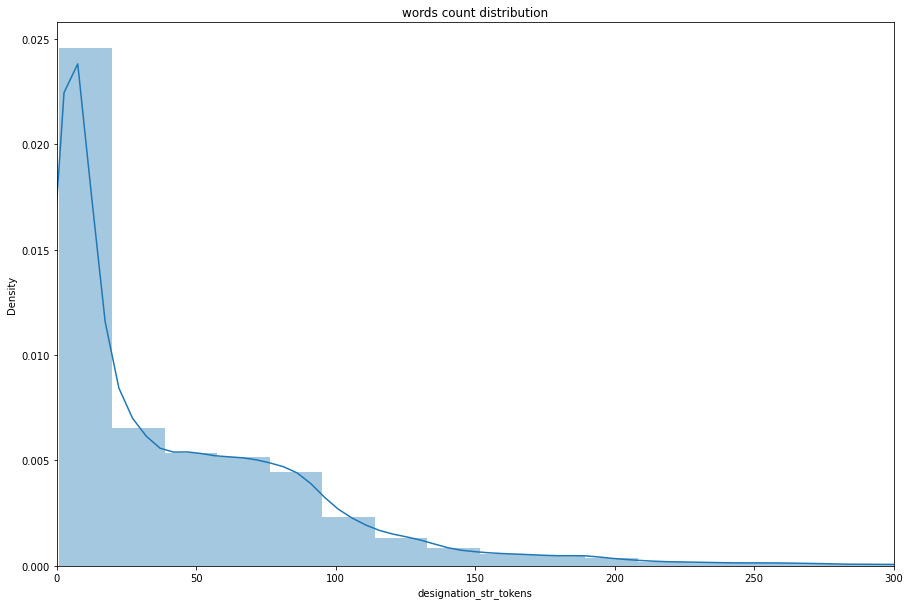

                                        98% of lines containing less than 206.0 words 


In [ ]:
#cell that explains the choosen value of text_size constant
word_count = data_train.designation_str_tokens.apply(lambda x : len(x.split(' ')))
plt.figure(figsize=(15,10))
sns.distplot(word_count)
plt.xlim(0, 300)
plt.title("words count distribution")
plt.show()

# choice to keep only 200 words per product text
print("                                        98% of lines containing less than {} words " .format(word_count.quantile(0.98)))

Respect of separation of data to keep completely unknown part of them to trained model<br />
(ratio 70% training - 20% for validation and 10% for test/evaluation)

In [ ]:
#split in training and validation sets for training phase and test set for model evaluation
target = data_train.prdtypecode
data_train = data_train.drop(['designation_orig','lang_designation','designation','designation_token_final','prdtypecode'],axis=1)

#Divide randomly data into training and (validation/test) sets
#maintaining proportion of classes equal (stratify option)
X_train, X_validtest, y_train, y_validtest = train_test_split(data_train,target, test_size=0.3, random_state=42)
#Divide randomly data into validation and test set
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest,y_validtest, test_size=0.33, random_state=42)

#for training purpose
df_train = pd.concat([X_train,y_train],axis=1)
df_train = df_train.reset_index(drop=True)
df_valid = pd.concat([X_valid,y_valid],axis=1)
df_valid = df_valid.reset_index(drop=True)

# for generalization purpose
df_test = pd.concat([X_test,y_test],axis=1)
df_test = df_test.reset_index(drop=True)



# df_train and df_valid will be used to build the batchs !!!!!!
df_train = create_col_class_onehot(df_train)
df_valid = create_col_class_onehot(df_valid)

#df_test will be used to evaluate the model 
df_test = create_col_class_onehot(df_test)


print("dimension training set   :",df_train.shape)
print("dimension validation set :",df_valid.shape)
print("dimension test set       :",df_test.shape)


dimension training set   : (59063, 4)
dimension validation set : (16959, 4)
dimension test set       : (8354, 4)


Tensorflow/keras tokenizer created and trained on corpus<br />
to be used to convert into numerical numbers each product sentences(texts) put in batchs

In [ ]:
#tokenizer created and trained on specific corpus (limited to texts of train set)
tokenizer = create_tokenizer(df_train['designation_str_tokens'])

# saving
with open('/content/drive/MyDrive/Rakuten/Rakuten_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)




# Use case : Image + text handling with classifier composed of 2 Dense layers and a BatchNormalization between


**Image chain : pretrained VGG16 model**<br>
**Text chain : embedding + GRU layers**<br>


In [ ]:


# VGG16 model used without its internal classifier 
base_model = VGG16(weights='imagenet', include_top=False,input_shape=target_size)
# Freezer les couches du VGG16
for layer in base_model.layers: 
    layer.trainable = False


image_input = tf.keras.Input(shape=target_size,name="image_input")
x = base_model(image_input)
encoded_image = Flatten()(x)

text_input = tf.keras.Input(shape=(text_size),name="text_input")
embedded_text = Embedding(max_features+1,640)(text_input)
y = GRU(640)(embedded_text)
encoded_txt = Flatten()(y)

# Concatenate both encoded images and text and pass through the classification layer.
#Normalization is mandatory for Neural Network with numerous hidden layers
#but this design pattern is anyway useful to ease weights calculation during descent gradient backpropagation 

concatenated = tf.keras.layers.Concatenate()([encoded_image, encoded_txt])
classifier_lay1 = tf.keras.layers.Dense(64, activation="relu")(concatenated)
classifier_lay2 = tf.keras.layers.BatchNormalization()(classifier_lay1)
classifier_lay3 = tf.keras.layers.Dropout(0.2)(classifier_lay2)
outputs = tf.keras.layers.Dense(27, activation="softmax")(classifier_lay3)

Summaries of the multimodal model layers with shape informations

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None, 200)]        0           []                               
                                                                                                  
 image_input (InputLayer)       [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 640)     30656640    ['text_input[0][0]']             
                                                                                                  
 vgg16 (Functional)             (None, 4, 4, 512)    14714688    ['image_input[0][0]']      

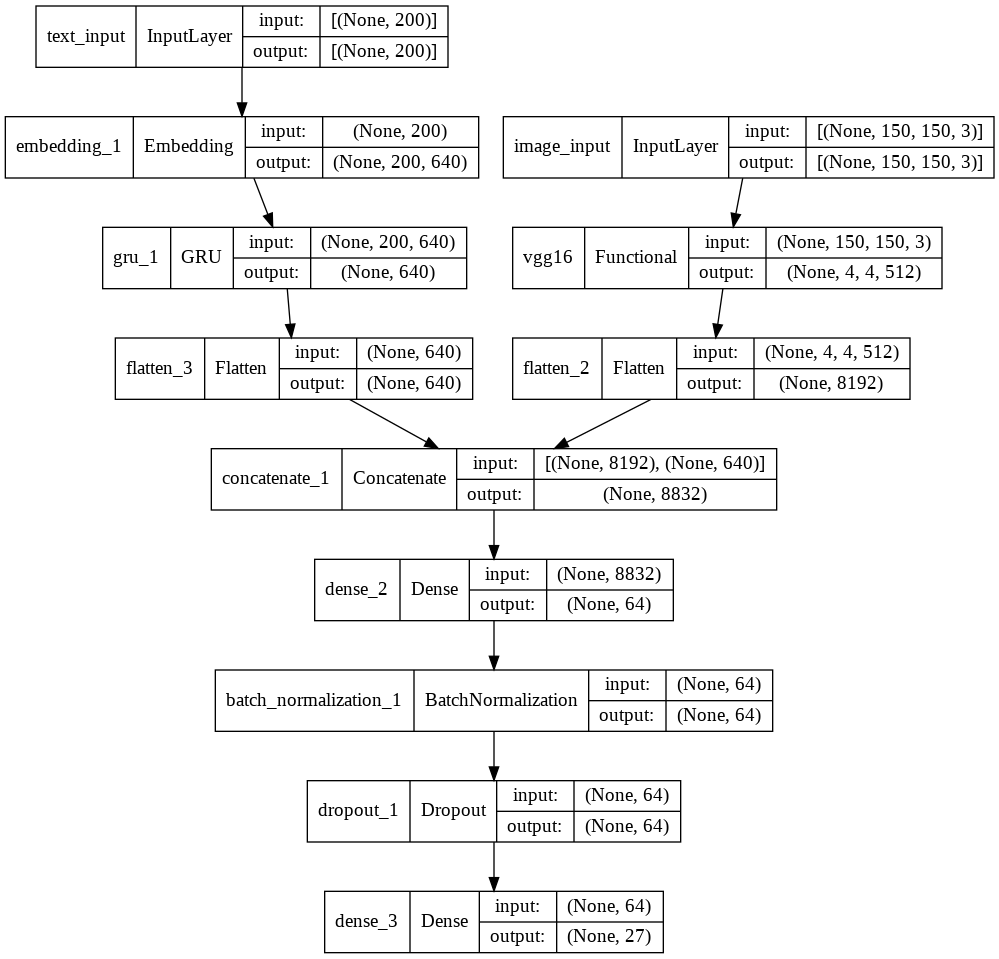

In [ ]:
#instanciate a model with two input tensors and a classifier composed of 2 dense layers
multimodal_model = tf.keras.Model([image_input,text_input],outputs)
# summarize layers
print(multimodal_model.summary())
tf.keras.utils.plot_model(multimodal_model, show_shapes=True)

Note : No customized loss function and metrics used to reduce possible side effect of imbalanced classes<br />
as small classes have normal f1-score in the mean so others stronger explanations to be searched for few classes with the weakest f1-score 
<br />
3 callbacks use to interact with the running model :<br />
Early Stop to limit training period if useful<br />
Model Checkpoint to save the model weights associated to a new minimum of validation score<br />
and a online plot of accuracy and loss updated after each epoch (thus no offline learning curve)


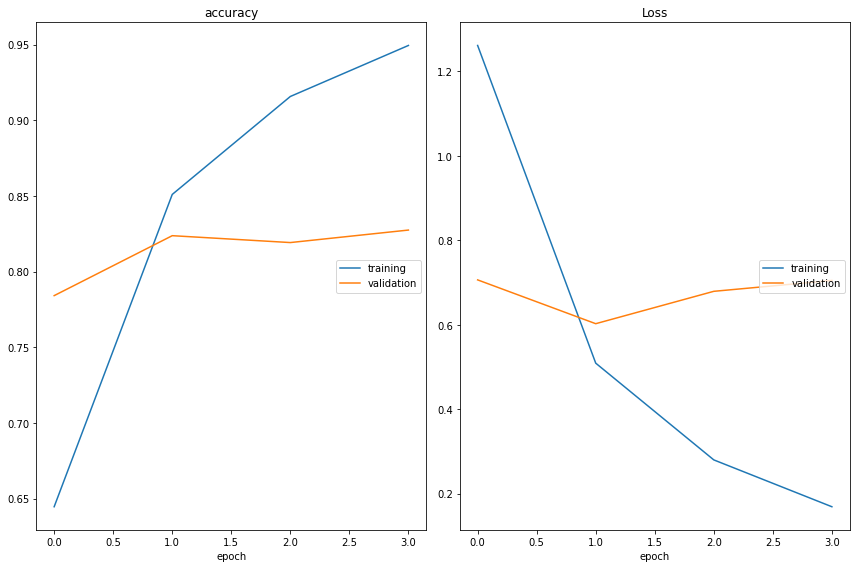

accuracy
	training         	 (min:    0.645, max:    0.949, cur:    0.949)
	validation       	 (min:    0.784, max:    0.827, cur:    0.827)
Loss
	training         	 (min:    0.169, max:    1.262, cur:    0.169)
	validation       	 (min:    0.602, max:    0.706, cur:    0.705)
1845/1845 [==============================] - 454s 246ms/step - loss: 0.1688 - accuracy: 0.9495 - val_loss: 0.7049 - val_accuracy: 0.8275

cell execution duration : 33.00 mn


In [ ]:
#CategoricalCrossentropy : Computes the crossentropy loss between the labels and predictions
#CategoricalAccuracy :  Calculates how often predictions match one-hot labels.
#learning_rate kept finally to the default value 0.001 after study
opt = Adam(learning_rate=0.001)
multimodal_model.compile(
    optimizer=opt, loss=['categorical_crossentropy'],
    metrics=['accuracy'])

#callback to stop training phase when val_loss is no more decreasing
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                         patience=2,
                                         mode='min',
                                         restore_best_weights=True)

# Saves TF/Keras model after each epoch in case of new best weights associated with a new min of val_loss 
checkpointer = ModelCheckpoint(filepath=path_name_model_best_weights, 
                               verbose=1, 
                               save_best_only=True)

#feature to display loss per epoch in live in the notebook, simple method
#if needed build-in TensorBoard gives more information through UI on a localhost
plot_loss = PlotLossesKerasTF()

# training of the fucntional model multimodal (Image + text)
traingen = CustomDataGen(df_train,
                         X_col_img={'nom_img':'nom_img'},
                         X_col_txt={'designation_str_tokens':'designation_str_tokens'},
                         y_col={'class_onehot': 'class_onehot'},
                         batch_size=32, input_size=target_size,input_text_size=text_size)

#print(type(traingen))

valgen = CustomDataGen(df_test,
                       X_col_img={'nom_img':'nom_img'},
                       X_col_txt={'designation_str_tokens':'designation_str_tokens'},
                       y_col={'class_onehot': 'class_onehot'},
                       batch_size=32, input_size=target_size,input_text_size=text_size)

start = time.time()
with tf.device(BESTDEV): # explicitly activates GPU if available
  history = multimodal_model.fit(traingen,validation_data=valgen,epochs=10,callbacks=[early_stopping,checkpointer,plot_loss])
end = time.time()
elapsed = round((end - start)/60)

print(f'\ncell execution duration : {elapsed:.2f} mn')

Evaluation of the model with test set<br />
the confusion matrix is used to display mismatched classes and prediction errors relationship if exist

  0%|          | 0/8354 [00:00<?, ?it/s]

                                            precision    recall  f1-score   support

                                  editions       0.48      0.72      0.58       285
                                 magazines       0.71      0.88      0.79       472
                    equipement_playstation       0.80      0.81      0.81       172
                             jouets_enfant       0.72      0.70      0.71       471
                                    livres       0.95      0.64      0.76       247
                     fournitures_scolaires       0.95      0.90      0.93       538
                           materiel_jardin       0.68      0.69      0.68       286
                        mobilier_interieur       0.79      0.84      0.81       464
                              jeux_enfants       0.70      0.44      0.54       210
                                   literie       0.87      0.91      0.89       422
                            livres_par_lot       0.86      0.73      0.79  

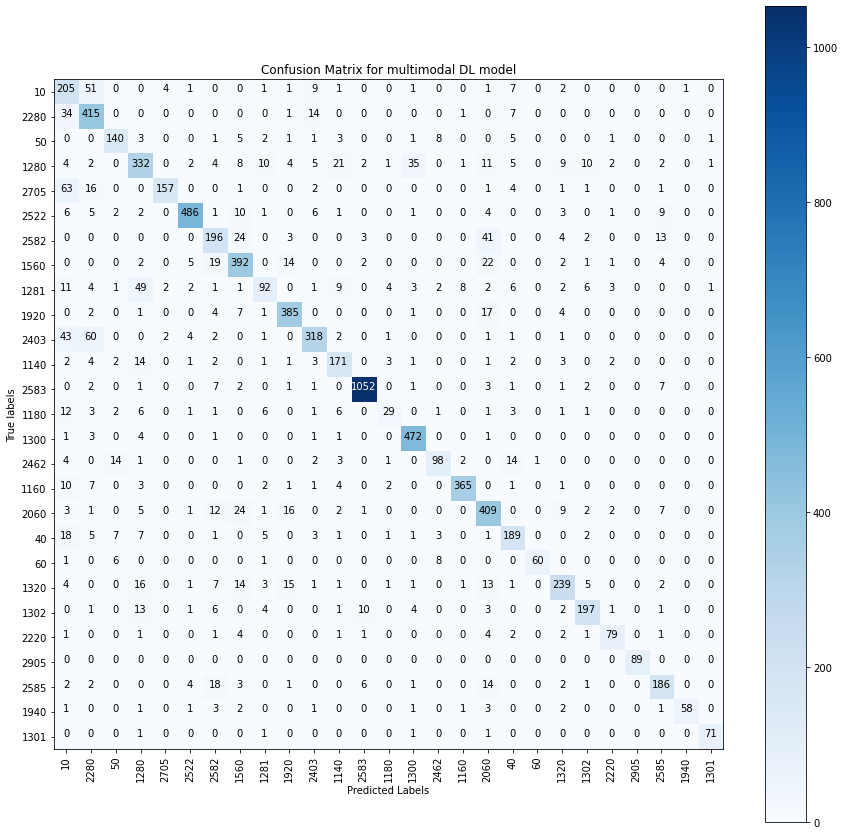

In [ ]:
#evaluate the model using the test dataset
multimodal_sav = load_model(path_name_model_best_weights)


test_pred_class = []
y_test_class = []


for i in tqdm(range(len(df_test))):
    img_tensor = transform_image(df_test['nom_img'].iloc[i], target_size)
    txt_tensor = transform_text(df_test['designation_str_tokens'].iloc[i], text_size)
    test_pred = multimodal_sav.predict([img_tensor,txt_tensor])
    test_pred_class_img = test_pred.argmax(axis = 1)
    test_pred_class.append(test_pred_class_img[0])


    y_test_class.append(df_test['class_onehot'].iloc[i])


print(metrics.classification_report(y_test_class, test_pred_class,target_names=name_class))

cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

classes = range(0,27)

plt.figure(figsize = (15,15))

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Confusion Matrix for multimodal DL model")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, list_class,rotation='vertical')
plt.yticks(tick_marks, list_class)


for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')
plt.show()


In [ ]:
print("mismatched classification listed when representing at least 10% of the right predictions amount of the class\n")
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
  ten_per_cent = ceil(cnf_matrix[i,i]/10)
  if(cnf_matrix[i,j] > ten_per_cent and i!=j):
    print("class {0} ({4}) wrongly predicted to class {1} ({5}) , {2} for {3} correct predictions ".format(list_class[i],list_class[j],cnf_matrix[i,j],cnf_matrix[i,i],name_class[i],name_class[j]))

mismatched classification listed when representing at least 10% of the right predictions amount of the class

class 10 (editions) wrongly predicted to class 2280 (magazines) , 51 for 205 correct predictions 
class 1280 (jouets_enfant) wrongly predicted to class 1300 (equipements_telecommandes) , 35 for 332 correct predictions 
class 2705 (livres) wrongly predicted to class 10 (editions) , 63 for 157 correct predictions 
class 2582 (materiel_jardin) wrongly predicted to class 1560 (mobilier_interieur) , 24 for 196 correct predictions 
class 2582 (materiel_jardin) wrongly predicted to class 2060 (decoration) , 41 for 196 correct predictions 
class 1281 (jeux_enfants) wrongly predicted to class 10 (editions) , 11 for 92 correct predictions 
class 1281 (jeux_enfants) wrongly predicted to class 1280 (jouets_enfant) , 49 for 92 correct predictions 
class 2403 (livres_par_lot) wrongly predicted to class 10 (editions) , 43 for 318 correct predictions 
class 2403 (livres_par_lot) wrongly predic

In conclusion :<br />
prediction errors done by the model are quite easy to understand for those who have study Rakuten classification<br />
as some classes are very close or even overlapped.<br />
pratically no added value to use image encoded features as ML or DL based on encoded text ONLY are around 81% of classification performance<br />
but for study purpose, it was fantastic 


Individual prediction with 5 examples <br />
Prerequisites on previous cells execution<br />
mandatory  : cell that imports all used librairies
then cells containing project constants,<br />
and finally both cells containing preprocessing and model processing functions<br />
including<br />
text preprocessing functions working on raw natural text (foreign language managed too as it is a real case for Rakuten challenge)<br />
are already present in the notebook<br /> 
preprocessing image with openCV also in the notebook<br />
and<br />
both image and text (numerical data) tensors 


In [7]:
%%bash
#cell valid in gColab environment using gDrive
# copy 5 images from gDrive to a dedicated destination directory on allocated VM
DEST="/tmp/predict/images"
echo "current images in directory /tmp/predict/images"
ls "$DEST"

# Check it has not been done
if [ -d "$DEST" ]; then
    echo "original images of Rakuten products for elementary prediction already present on VM gColab"
else
    # Create directory and copy the 5 first original images of Rakuten dataset 
    mkdir -p "$DEST"
    cp /content/drive/MyDrive/Rakuten/image_row*.jpg "$DEST"
    echo "Images transferred from gDrive to VM gColab"
fi

current images in directory /tmp/predict/images
image_row0.jpg
image_row1.jpg
image_row2.jpg
image_row3.jpg
image_row4.jpg
Images transferred from gDrive to VM gColab


ls: cannot access '/tmp/predict/images': No such file or directory


Rakuten class : 10 - editions  and  predicted class : 2522 - fournitures_scolaires
next potential classes according to softmax decreasing probabilities : 1320 - materiel_bebe and 2060 - decoration
for associated text :  Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design
and its related image : 


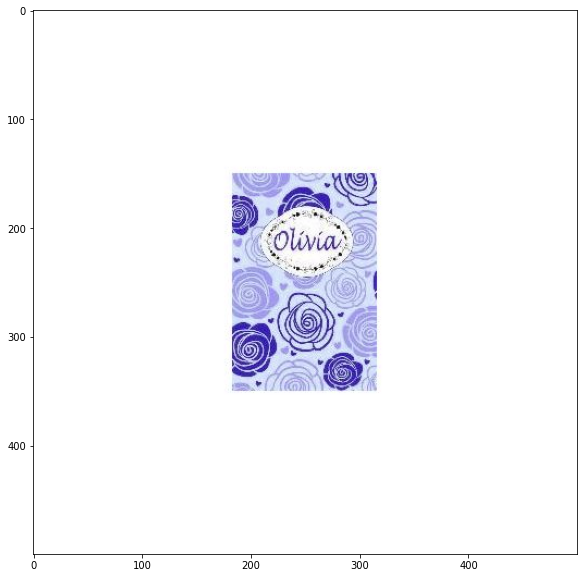


Rakuten class : 2280 - magazines  and  predicted class : 2280 - magazines
next potential classes according to softmax decreasing probabilities : 10 - editions and 2403 - livres_par_lot
for associated text :  Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans.
and its related image : 


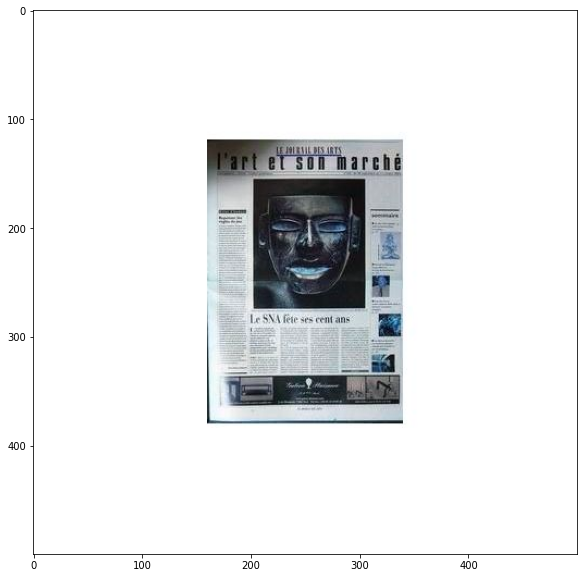


Rakuten class : 50 - equipement_playstation  and  predicted class : 50 - equipement_playstation
next potential classes according to softmax decreasing probabilities : 2585 - accessoires_outil and 2522 - fournitures_scolaires
for associated text :  Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U. Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant. Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad Caractéristiques: Modèle: Speedlink PILOT STYLE Touch Pen Couleur: Bleu Ref. Fabricant: SL-3468-BE Compatibilité: GamePad Nintendo Wii U Forme particulièrement ergonomique excellente tenue en main Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile En bonus : Support inclu pour GamePad

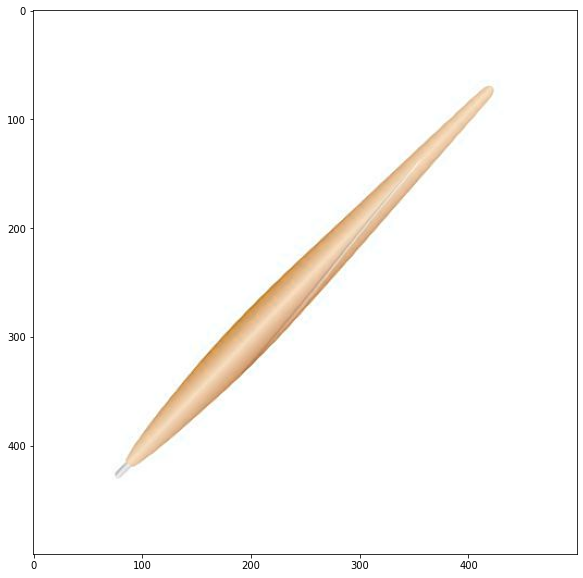


Rakuten class : 1280 - jouets_enfant  and  predicted class : 1280 - jouets_enfant
next potential classes according to softmax decreasing probabilities : 1140 - figurine and 1281 - jeux_enfants
for associated text :  Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt) 
and its related image : 


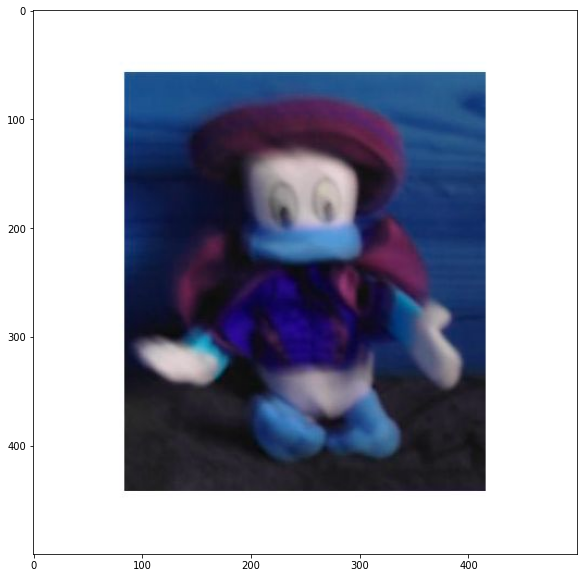


Rakuten class : 2705 - livres  and  predicted class : 10 - editions
next potential classes according to softmax decreasing probabilities : 2522 - fournitures_scolaires and 2705 - livres
for associated text :  La Guerre Des Tuques Luc a des idées de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en être le vainqueur incontesté. Mais Sophie s'en mêle et chambarde tous ses plans...
and its related image : 


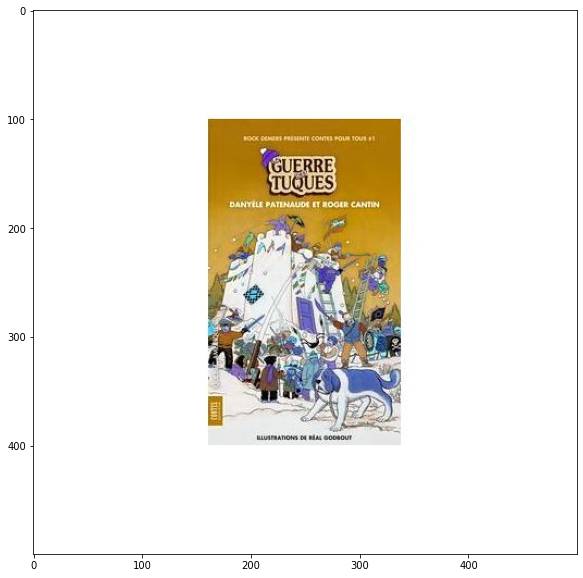

In [25]:
#load model to do elementary predictions
#location of raw and then cropped images on VM gColab
DEST = "/tmp/predict/images"
multimodal_sav_demo = load_model(path_name_model_best_weights)

# load tokenizer used when model was trained
with open('/content/drive/MyDrive/Rakuten/Rakuten_tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


list_images_5samples = ["image_row0.jpg","image_row1.jpg","image_row2.jpg","image_row3.jpg","image_row4.jpg"]
text_row0 = "Olivia: Personalisiertes Notizbuch / 150 Seiten / Punktraster / Ca Din A5 / Rosen-Design"
text_row1 = "Journal Des Arts (Le) N° 133 Du 28/09/2001 - L'art Et Son Marche Salon D'art Asiatique A Paris - Jacques Barrere - Francois Perrier - La Reforme Des Ventes Aux Encheres Publiques - Le Sna Fete Ses Cent Ans."
text_row2 = "Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U. Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant. Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad Caractéristiques: Modèle: Speedlink PILOT STYLE Touch Pen Couleur: Bleu Ref. Fabricant: SL-3468-BE Compatibilité: GamePad Nintendo Wii U Forme particulièrement ergonomique excellente tenue en main Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile En bonus : Support inclu pour GamePad "
text_row3 = "Peluche Donald - Europe - Disneyland 2000 (Marionnette À Doigt) "
text_row4 = "La Guerre Des Tuques Luc a des idées de grandeur. Il veut organiser un jeu de guerre de boules de neige et s'arranger pour en être le vainqueur incontesté. Mais Sophie s'en mêle et chambarde tous ses plans..."
list_text_5samples = [text_row0 , text_row1 , text_row2 , text_row3 , text_row4]

true_label_5samples = [0, 1, 2, 3, 4]
test_pred_class = []
test_pred_3best_classes = []
three_best_classes = []
y_test_class = []


for i in range(5):  
    cropped_image_name = suppress_white_areas(DEST,list_images_5samples[i])
    cropped_image_name = DEST + "/" + cropped_image_name
    img_tensor = transform_image(cropped_image_name, target_size)

    str_tokens = preprocessing_text(list_text_5samples[i])
    txt_tensor = transform_text(str_tokens, text_size)
    three_best_classes = []
    test_pred = multimodal_sav_demo.predict([img_tensor,txt_tensor])
    test_pred_class_img = test_pred.argmax(axis = 1)
    # this highest probability set to 0 to find out the second better
    test_pred[0][test_pred_class_img] = 0
    test_pred_class_img2 = test_pred.argmax(axis = 1)
    # this second probability set to 0 to find out the thrid better
    test_pred[0][test_pred_class_img2] = 0
    test_pred_class_img3 = test_pred.argmax(axis = 1)
    test_pred_class.append(test_pred_class_img[0])
    #we keep 3 classes with best probabilities given by softmax at output of the model 
    three_best_classes.append(test_pred_class_img[0])
    three_best_classes.append(test_pred_class_img2[0])
    three_best_classes.append(test_pred_class_img3[0])
    test_pred_3best_classes.append(three_best_classes)

    y_test_class.append(true_label_5samples[i])

for i in range(5):
  print("Rakuten class : {0}  and  predicted class : {1}".format(name_class[y_test_class[i]],name_class[test_pred_class[i]]))
  print("next potential classes according to softmax decreasing probabilities : {0} and {1}".format(name_class[test_pred_3best_classes[i][1]],name_class[test_pred_3best_classes[i][2]]))
  print("for associated text : ",list_text_5samples[i])
  print("and its related image : ")
  full_name = DEST + "/" + list_images_5samples[i]
  img_color = cv2.imread(full_name, cv2.IMREAD_COLOR) # read the image
  plt.figure(figsize=(20, 10))
  plt.imshow(img_color)
  plt.show();
  print("")





